In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import warnings
warnings.filterwarnings("ignore")

plt.rcParams.update({
    'savefig.dpi': 300, 
    "figure.dpi": 300,
    "font.family": "Arial",
    "font.size": 6,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    "xtick.major.size": 3,
    "ytick.major.size": 3,
    "lines.linewidth": 0.8,
})

cm = 1/2.54  # centimeters in inches

In [2]:
from reproject import reproject_interp

from astropy.io import fits
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord
from astropy import units

from matplotlib.patches import Ellipse, Rectangle

### Tricolor images
Load radio, X-ray, and infrared data, and reproject them

In [3]:
# load multiwavelength data
fwise = fits.open("../data/tricolor_fits/wise_raw.fits")
fradio = fits.open("../data/tricolor_fits/radio_raw.fits")
fxray = fits.open("../data/tricolor_fits/chandra_raw.fits")

wcswise = WCS(fwise[0].header)
wcsradio = WCS(fradio[0].header)
wcsxray = WCS(fxray[0].header)

wisearr = fwise[0].data
radioarr, footprint = reproject_interp(fradio[0], fwise[0].header)
xrayarr, footprint = reproject_interp(fxray[0], fwise[0].header)


def normalise(arr, arr_min=None, arr_max=None):
    ### normalise the data so that it does not look bad
    arr = arr.copy()
    
    if arr_min is None: arr_min = arr.min()
    if arr_max is None: arr_max = arr.max()
    
    arr[arr < arr_min] = arr_min
    arr[arr > arr_max] = arr_max
    
    return (arr-arr_min) / (arr_max - arr_min)

radio_narr = normalise(radioarr, arr_min=-0.0003, arr_max=0.0025)
wise_narr = normalise(wisearr, arr_min=1500, arr_max=3200)
xray_narr = normalise(xrayarr, arr_min=4, arr_max=6)

rgb_composite = np.dstack((radio_narr, xray_narr, wise_narr, ))

Load deeper IR follow-ups

In [4]:
srccoord = SkyCoord("18h32m48.4589679s -09d11m15.298140s")

def cutout_data(data, wcs, coord=srccoord, radius=30*units.arcsec):
    return Cutout2D(data, srccoord, size=radius, wcs=wcs)

def get_ellipse(ax, coord, width, height=None, angle=None, **kwargs):
    """
    Create an ellipse patch for the given coordinates to highlight sources
    """
    if height is None: height = width
    if angle is None: angle = 0
    return Ellipse(
        xy=(coord.ra.value, coord.dec.value), width=width, height=height, angle=angle,
        transform=ax.get_transform("icrs"), **kwargs
    )

### load fourstar and wirc data and make cutout to zoom in
hdul = fits.open("../data/fourstar.J1832-0911.fits")
kdata = hdul[0].data
kheader = hdul[0].header
kwcs = WCS(kheader).celestial

kcut = cutout_data(kdata, kwcs, radius=10*units.arcsec)
kcutl = cutout_data(kdata, kwcs, radius=35*units.arcsec)

hdul = fits.open("../data/wirc.J1832-0911.fits")
jdata = hdul[0].data
jheader = hdul[0].header
jwcs = WCS(jheader).celestial

jcut = cutout_data(jdata, jwcs, radius=10*units.arcsec)
jcutl = cutout_data(jdata, jwcs, radius=35*units.arcsec)


In [5]:
### load chandra data
hdul = fits.open("../data/chandra.2402obs.field.bin2.fits")
xdata = hdul[0].data
xheader = hdul[0].header
xwcs = WCS(xheader).celestial

xcut = cutout_data(xdata, xwcs, radius=15*units.arcsec)
xcutl = cutout_data(xdata, xwcs, radius=35*units.arcsec)

### load radio data for overlay
hdul = fits.open("../data/tricolor_fits/radio_raw.fits")
rdata = hdul[0].data
rheader = hdul[0].header
rwcs = WCS(rheader).celestial

rcut = cutout_data(rdata, rwcs, radius=15*units.arcsec)
rcutl = cutout_data(rdata, rwcs, radius=35*units.arcsec)

In [6]:
### supernova remnant position
snrra, snrdec = 278.3419639, -9.1636636
snra, snrb = 0.2066115, 0.1850691
snrpa = 0 # degree

### fermi source position
fermira = 278.2404
fermidec = -09.2332
amaj = 0.0974
bmin = 0.0798
pa = 49.92

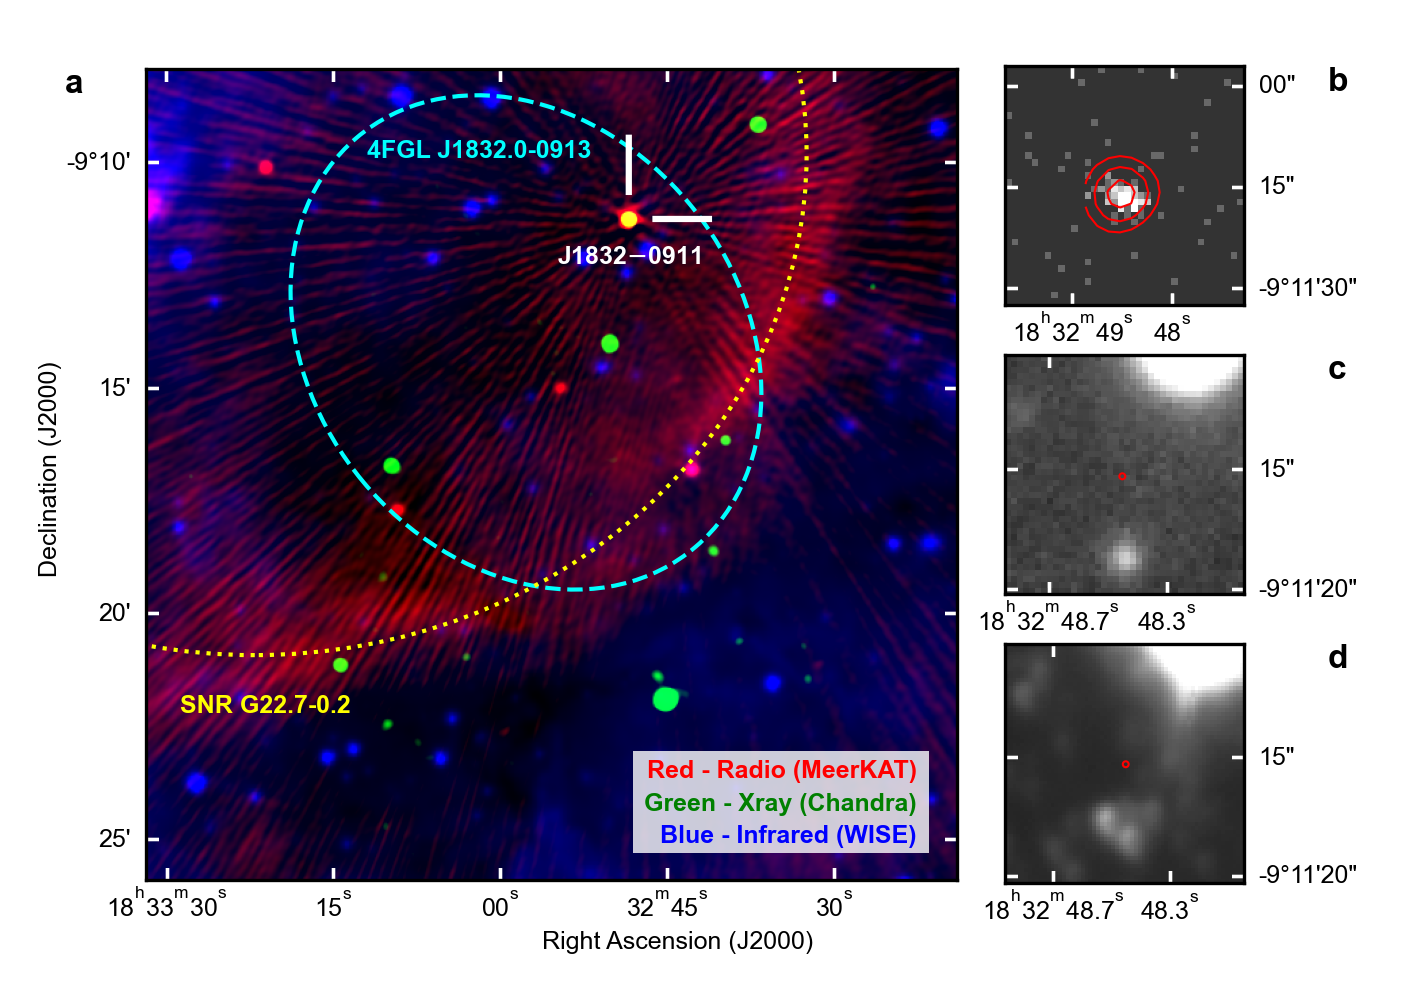

In [8]:
fig = plt.figure(figsize=(12*cm, 9*cm), dpi=300)
gs = GridSpec(figure=fig, ncols=4, nrows=3, hspace=0.2, wspace=0.2)

ax = fig.add_subplot(gs[:, :3], projection=wcswise)
# rgb_composite_new = np.dstack((radio_narr, xray_narr, np.zeros(radio_narr.shape), ))

# ax.imshow(rgb_composite_new, origin="lower", )
ax.imshow(rgb_composite, origin="lower",)
oxlims = ax.get_xlim()
oylims = ax.get_ylim()

ell = Ellipse(
    (fermira, fermidec), 2*amaj / np.cos(np.deg2rad(fermidec)),
    2*bmin, angle=pa, # this is for position angle
    edgecolor="cyan", lw=1, facecolor="none",
    transform = ax.get_transform("fk5"), ls="--"
)
ax.add_patch(ell)

ell = Ellipse(
    (snrra, snrdec), 2*snra, 2*snrb, angle=snrpa,
    edgecolor="yellow", lw=1, facecolor="none",
    transform = ax.get_transform("fk5"), ls=":"
)
ax.add_patch(ell)

ax.text(
    278.30, -9.165, "4FGL J1832.0-0913", 
    transform=ax.get_transform("fk5"), color="cyan",
    weight="bold"
)

ax.text(
    278.37, -9.37, "SNR G22.7-0.2", 
    transform=ax.get_transform("fk5"), color="yellow",
    weight="bold"
)


ax.set_xlim(*oxlims)
ax.set_ylim(*oylims)

ax.coords[0].set_ticks(color="white")
ax.coords[1].set_ticks(color="white")

ax.coords[1].set_axislabel(" ", )
ax.coords[0].set_axislabel(" ", )

plt.text(0.5, 0.055, s="Right Ascension (J2000)", va="center", ha="center", transform=fig.transFigure)
plt.text(0.05, 0.5, s="Declination (J2000)", va="center", ha="left", rotation=90, transform=fig.transFigure)

# ax.text(
#     0.03, 0.95, s="(a)", ha="left", va="center",  weight="bold",
#     transform=ax.transAxes, color="white", fontsize=8
# )
ax.text(
    -0.1, 1.0, s="a", ha="left", va="top",  weight="bold",
    transform=ax.transAxes, color="k", fontsize=8
)

ax.tick_params(axis='x', which='major', pad=4)

#### add source cross...
unitspace = 0.01

ax.plot(
    [srccoord.ra.degree, srccoord.ra.degree],
    [srccoord.dec.degree+unitspace, srccoord.dec.degree + 3*unitspace],
    color="white", lw=1.5, transform = ax.get_transform("fk5"),
)

ax.plot(
    [srccoord.ra.degree - unitspace, srccoord.ra.degree - 3*unitspace],
    [srccoord.dec.degree, srccoord.dec.degree],
    color="white", lw=1.5, transform = ax.get_transform("fk5"),
)

ax.text(
    srccoord.ra.degree, srccoord.dec.degree - 0.01, r"J1832$-$0911",
    ha="center", va="top", usetex=False, color="white",
    weight="bold", transform = ax.get_transform("fk5"),
)

rect = Rectangle(
    (0.6, 0.034), 0.365, 0.125, transform=ax.transAxes, edgecolor="none",
    facecolor="white", alpha=0.8
)
ax.add_patch(rect)

ax.text(
    0.95, 0.12, "Red - Radio (MeerKAT)", transform=ax.transAxes, color="red", 
    va="bottom", ha="right", weight="bold"
)
ax.text(
    0.95, 0.08, "Green - Xray (Chandra)", transform=ax.transAxes, color="green", 
    va="bottom", ha="right", weight="bold"
)
ax.text(
    0.95, 0.04, "Blue - Infrared (WISE)", transform=ax.transAxes, color="blue", 
    va="bottom", ha="right", weight="bold"
)

#### add X-ray cutout...
ax = fig.add_subplot(gs[0, 3], projection=xcutl.wcs)
ax.imshow(xcutl.data, vmax=5, vmin=-1, cmap="Greys_r")
ax.contour(
    rcut.data, transform=ax.get_transform(rcut.wcs), 
    levels=[0.03, 0.04, 0.05], colors="red", linewidths=0.5,
)

ax.coords[1].set_axislabel_position("right")
ax.coords[1].set_ticklabel_position("right")
ax.coords[0].set_axislabel(" ")
ax.coords[1].set_axislabel(" ")

ax.coords[0].set_ticks(spacing=15*units.arcsec)
ax.coords[1].set_ticks(spacing=15*units.arcsec)

ax.coords[0].set_ticks(color="white")
ax.coords[1].set_ticks(color="white")

ax.tick_params(axis='x', which='major', pad=4)

# ax.text(
#     0.06, 0.85, s="(b)", ha="left", va="center",  weight="bold",
#     transform=ax.transAxes, color="white", fontsize=8
# )
ax.text(
    1.35, 1.0, s="b", ha="left", va="top",  weight="bold",
    transform=ax.transAxes, color="k", fontsize=8
)


############ add WIRC and FourSTAR
ax = fig.add_subplot(gs[1, 3], projection=jcut.wcs)
ax.imshow(jcut.data, vmax=40, vmin=-10, cmap="Greys_r")
ell = get_ellipse(ax, srccoord, width=50*0.005/3600, edgecolor="red", facecolor="none", lw=0.5)
ax.add_patch(ell)

ax.coords[1].set_axislabel_position("right")
ax.coords[1].set_ticklabel_position("right")
ax.coords[0].set_axislabel(" ")
ax.coords[1].set_axislabel(" ")

ax.coords[0].set_ticks(spacing=5*units.arcsec)
ax.coords[1].set_ticks(spacing=5*units.arcsec)

ax.coords[0].set_ticks(color="white")
ax.coords[1].set_ticks(color="white")

ax.tick_params(axis='x', which='major', pad=4)

# ax.text(
#     0.06, 0.85, s="(c)", ha="left", va="center",  weight="bold",
#     transform=ax.transAxes, color="white", fontsize=8
# )
ax.text(
    1.35, 1.0, s="c", ha="left", va="top",  weight="bold",
    transform=ax.transAxes, color="k", fontsize=8
)

####

ax = fig.add_subplot(gs[2, 3], projection=kcut.wcs)
ax.imshow(kcut.data, vmax=300, vmin=-50, cmap="Greys_r")
ell = get_ellipse(ax, srccoord, width=50*0.005/3600, edgecolor="red", facecolor="none", lw=0.5)
ax.add_patch(ell)

# ax.text(
#     0.06, 0.85, s="(d)", ha="left", va="center",  weight="bold",
#     transform=ax.transAxes, color="white", fontsize=8
# )
ax.text(
    1.35, 1.0, s="d", ha="left", va="top",  weight="bold",
    transform=ax.transAxes, color="k", fontsize=8
)

ax.coords[1].set_axislabel_position("right")
ax.coords[1].set_ticklabel_position("right")
ax.coords[0].set_axislabel(" ")
ax.coords[1].set_axislabel(" ")

ax.coords[0].set_ticks(color="white")
ax.coords[1].set_ticks(color="white")

ax.coords[0].set_ticks(spacing=5*units.arcsec)
ax.coords[1].set_ticks(spacing=5*units.arcsec)

ax.tick_params(axis='x', which='major', pad=4)

# fig.savefig("multilambda_field_image.pdf", bbox_inches="tight", dpi=300)
fig.savefig("multilambda_field_image.jpg", bbox_inches="tight", dpi=300)

### Stellar companion limit

In [1]:
from astropy import units as u, constants as c
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
from dustmaps.bayestar import BayestarQuery
from astropy.coordinates import SkyCoord

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import warnings
warnings.filterwarnings("ignore")

plt.rcParams.update({
    'savefig.dpi': 300, 
    "figure.dpi": 300,
    "font.family": "Arial",
    "font.size": 6,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    "xtick.major.size": 3,
    "ytick.major.size": 3,
    "lines.linewidth": 0.8,
})

cm = 1/2.54  # centimeters in inches

In [2]:
sourcec = SkyCoord("18:32:48.459", "-09:11:15.29", unit=("hour", "deg"))

# http://argonaut.skymaps.info/usage
# grizJKs
Alambda = np.array([3.518, 2.617, 1.971, 1.549, 0.79, 0.30])

### query skymaps for extinction info
import os

if not os.path.exists("dustmap.bayestar.J1832-0911.npz"):
    bayestar = BayestarQuery(max_samples=2)
    ebmv = bayestar(sourcec, mode="random_sample")
    np.savez("dustmap.bayestar.J1832-0911.npz", ebmv=ebmv, dist=bayestar.distances)
else:
    print("dusmtmap already exists... will load the one on the disk...")

dusmtmap already exists... will load the one on the disk...


Stellar type constraints based on current observations

In [3]:
bs = np.load("dustmap.bayestar.J1832-0911.npz")

distances = bs["dist"] * u.kpc
distancemoduli = 5 * np.log10((distances / (10 * u.pc)).decompose())

# limits (otherwise)
# JK are Vega, others are AB
# grizJKs
# J limit from P200/WIRC
# Ks limit from Magellan/FourStar
limits = np.array([23.7, 23.6, 23.5, 22.9, 19.98, 19.86])
# limits from JWST calculator for a one-hour observation
limits_jwst = np.array([23.7, 23.6, 23.5, 22.9, 19.98, 24.5])

# load star magnitude info
stars = Table.read(
    "EEM_dwarf_UBVIJHK_colors_Teff.txt",
    format="ascii.commented_header",
    fill_values=[("...", "0"), (".....", "0"), ("....", "0")],
)

### case 1 - use dustmap to estimate the extinction
dmin = np.zeros(len(stars)) * u.kpc
ebmv = bs["ebmv"] 

for i in range(len(stars)):
    Jpred = stars["M_J"][i] + distancemoduli + ebmv * Alambda[-2]
    Kpred = stars["M_Ks"][i] + distancemoduli + ebmv * Alambda[-1]
    if ~stars["M_J"].mask[i]:
        if Jpred.max() >= limits[-2]:
            jJ = np.where(Jpred >= limits[-2])[0][0]
        else:
            jJ = len(Jpred) - 1
    else:
        jJ = 0
    if ~stars["M_Ks"].mask[i]:
        if Kpred.max() >= limits[-1]:
            jK = np.where(Kpred >= limits[-1])[0][0]
        else:
            jK = len(Kpred) - 1
    else:
        jK = 0
    if jK == 0 and jJ == 0:
        dmin[i] = np.nan
    else:
        dmin[i] = distances[max(jJ, jK)]
dmin_ar = dmin

### case 2 - use a nearby HMXB to estimate the extinction
dmin = np.zeros(len(stars)) * u.kpc
ebmv = 21.6/3.1/6.7 * distances.value

for i in range(len(stars)):
    Jpred = stars["M_J"][i] + distancemoduli + ebmv * Alambda[-2]
    Kpred = stars["M_Ks"][i] + distancemoduli + ebmv * Alambda[-1]
    if ~stars["M_J"].mask[i]:
        if Jpred.max() >= limits[-2]:
            jJ = np.where(Jpred >= limits[-2])[0][0]
        else:
            jJ = len(Jpred) - 1
    else:
        jJ = 0
    if ~stars["M_Ks"].mask[i]:
        if Kpred.max() >= limits[-1]:
            jK = np.where(Kpred >= limits[-1])[0][0]
        else:
            jK = len(Kpred) - 1
    else:
        jK = 0
    if jK == 0 and jJ == 0:
        dmin[i] = np.nan
    else:
        dmin[i] = distances[max(jJ, jK)]

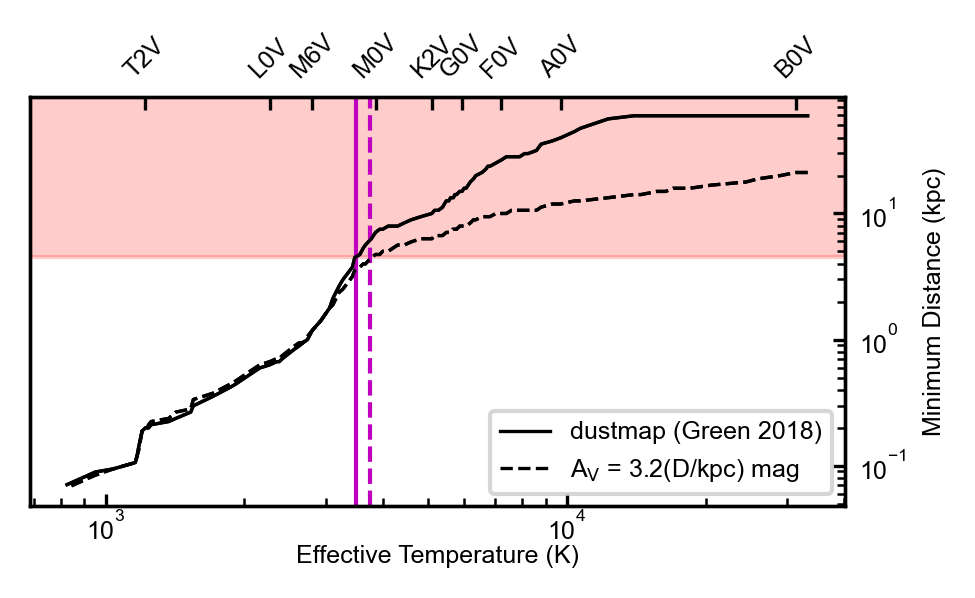

In [4]:
fig = plt.figure(figsize=(8.9*cm, 4.5*cm), dpi=300)

ax = fig.add_subplot(1, 1, 1)
fontsize = plt.rcParams["font.size"]

ax.plot(stars["Teff"], dmin_ar, color="k")
ax.plot(stars["Teff"], dmin, color="k", ls="--")
ax.set_xscale("log")
ax.set_yscale("log")

ax.tick_params(axis="x", which="major", pad=1)
ax.set_xlabel("Effective Temperature (K)", fontsize=fontsize, labelpad=0.1)
ax.set_ylabel("Minimum Distance (kpc)", fontsize=fontsize)
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
plt.fill_between(xlim, 4.5, ylim[1], color="r", alpha=0.2)
plt.gca().set_xlim(xlim)
plt.gca().set_ylim(ylim)

# SpT = ["T2V", "L2V", "M8V", "M4V", "M0V", "K4V", "G0V", "F0V", "A0V", "B0V"]
SpT = ["T2V", "L0V", "M6V", "M0V", "K2V", "G0V", "F0V", "A0V", "B0V"]
Teff = [stars["Teff"][stars["SpT"] == x].data[0] for x in SpT]

ax.axvline(x=3500, color="m", ls="-", lw=1)
ax.axvline(x=3750, color="m", ls="--", lw=1)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
# ax.text(
#     x=0., y=-0.2, 
#     s = "Note - Minimum Distance Constraints for different stellar spectral types from current observations",
#     transform=ax.transAxes, va="top", ha="left", fontsize=4
# )

ax = plt.gca()
ax2 = ax.twiny()
# ax2.loglog(stars["Teff"], dmin)
ax2.plot(stars["Teff"], dmin_ar, color="k", label="dustmap (Green 2018)")
ax2.plot(stars["Teff"], dmin, color="k", ls="--", label=r"A$_{\rm V}$ = 3.2(D/kpc) mag")
ax2.set_xscale("log"); ax2.set_yscale("log")
ax2.set_xticks([], minor=True)
ax2.set_xticks(Teff)
ax2.set_xticklabels(SpT, fontsize=fontsize, rotation=45)

ax2.legend(loc="lower right")

# fig.savefig("./oir_companion_constraint.pdf", bbox_inches="tight", dpi=1200)
fig.savefig("./oir_companion_constraint.jpg", format="jpg", bbox_inches="tight", dpi=300)
# plt.show()

Stellar type constraints based on one-hour JWST observation

In [22]:
bs = np.load("dustmap.bayestar.J1832-0911.npz")

distances = bs["dist"] * u.kpc
distancemoduli = 5 * np.log10((distances / (10 * u.pc)).decompose())

# limits from JWST calculator for a one-hour observation
limits = np.array([23.7, 23.6, 23.5, 22.9, 19.98, 24.5])

# load star magnitude info
stars = Table.read(
    "EEM_dwarf_UBVIJHK_colors_Teff.txt",
    format="ascii.commented_header",
    fill_values=[("...", "0"), (".....", "0"), ("....", "0")],
)

### case 1 - use dustmap to estimate the extinction
dmin = np.zeros(len(stars)) * u.kpc
ebmv = bs["ebmv"] 

for i in range(len(stars)):
    Jpred = stars["M_J"][i] + distancemoduli + ebmv * Alambda[-2]
    Kpred = stars["M_Ks"][i] + distancemoduli + ebmv * Alambda[-1]
    if ~stars["M_J"].mask[i]:
        if Jpred.max() >= limits[-2]:
            jJ = np.where(Jpred >= limits[-2])[0][0]
        else:
            jJ = len(Jpred) - 1
    else:
        jJ = 0
    if ~stars["M_Ks"].mask[i]:
        if Kpred.max() >= limits[-1]:
            jK = np.where(Kpred >= limits[-1])[0][0]
        else:
            jK = len(Kpred) - 1
    else:
        jK = 0
    if jK == 0 and jJ == 0:
        dmin[i] = np.nan
    else:
        dmin[i] = distances[max(jJ, jK)]
dmin_ar = dmin

### case 2 - use a nearby HMXB to estimate the extinction
dmin = np.zeros(len(stars)) * u.kpc
ebmv = 21.6/3.1/6.7 * distances.value

for i in range(len(stars)):
    Jpred = stars["M_J"][i] + distancemoduli + ebmv * Alambda[-2]
    Kpred = stars["M_Ks"][i] + distancemoduli + ebmv * Alambda[-1]
    if ~stars["M_J"].mask[i]:
        if Jpred.max() >= limits[-2]:
            jJ = np.where(Jpred >= limits[-2])[0][0]
        else:
            jJ = len(Jpred) - 1
    else:
        jJ = 0
    if ~stars["M_Ks"].mask[i]:
        if Kpred.max() >= limits[-1]:
            jK = np.where(Kpred >= limits[-1])[0][0]
        else:
            jK = len(Kpred) - 1
    else:
        jK = 0
    if jK == 0 and jJ == 0:
        dmin[i] = np.nan
    else:
        dmin[i] = distances[max(jJ, jK)]

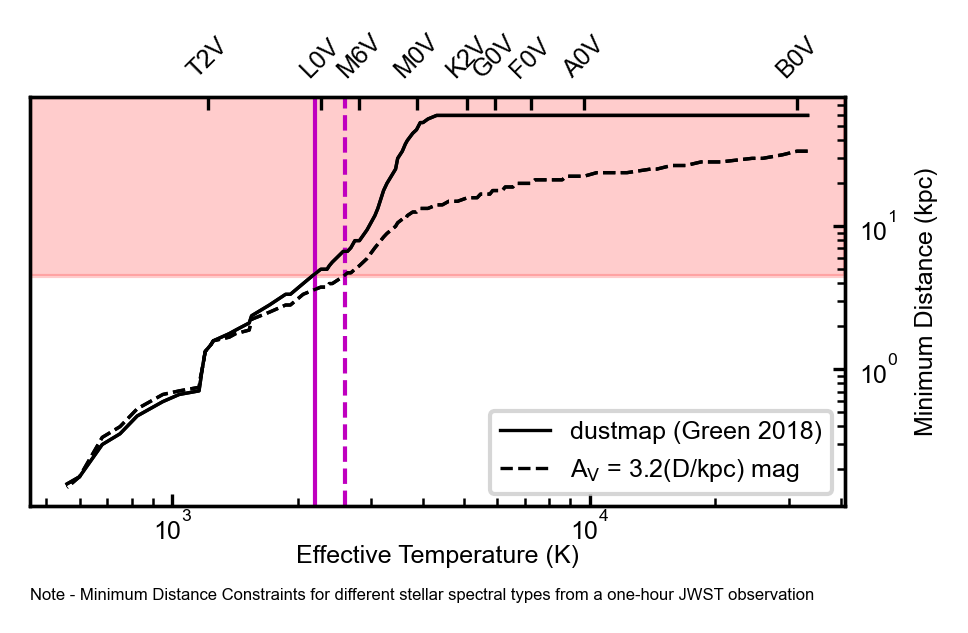

In [29]:
fig = plt.figure(figsize=(8.9*cm, 4.5*cm), dpi=300)

ax = fig.add_subplot(1, 1, 1)
fontsize = plt.rcParams["font.size"]

ax.plot(stars["Teff"], dmin_ar, color="k")
ax.plot(stars["Teff"], dmin, color="k", ls="--")
ax.set_xscale("log")
ax.set_yscale("log")

ax.tick_params(axis="x", which="major", pad=1)
ax.set_xlabel("Effective Temperature (K)", fontsize=fontsize, labelpad=0.1)
ax.set_ylabel("Minimum Distance (kpc)", fontsize=fontsize)
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
plt.fill_between(xlim, 4.5, ylim[1], color="r", alpha=0.2)
plt.gca().set_xlim(xlim)
plt.gca().set_ylim(ylim)

# SpT = ["T2V", "L2V", "M8V", "M4V", "M0V", "K4V", "G0V", "F0V", "A0V", "B0V"]
SpT = ["T2V", "L0V", "M6V", "M0V", "K2V", "G0V", "F0V", "A0V", "B0V"]
Teff = [stars["Teff"][stars["SpT"] == x].data[0] for x in SpT]

ax.axvline(x=2200, color="m", ls="-", lw=1)
ax.axvline(x=2600, color="m", ls="--", lw=1)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.text(
    x=0., y=-0.2, 
    s = "Note - Minimum Distance Constraints for different stellar spectral types from a one-hour JWST observation",
    transform=ax.transAxes, va="top", ha="left", fontsize=4
)

ax = plt.gca()
ax2 = ax.twiny()
# ax2.loglog(stars["Teff"], dmin)
ax2.plot(stars["Teff"], dmin_ar, color="k", label="dustmap (Green 2018)")
ax2.plot(stars["Teff"], dmin, color="k", ls="--", label=r"A$_{\rm V}$ = 3.2(D/kpc) mag")
ax2.set_xscale("log"); ax2.set_yscale("log")
ax2.set_xticks([], minor=True)
ax2.set_xticks(Teff)
ax2.set_xticklabels(SpT, fontsize=fontsize, rotation=45)

ax2.legend(loc="lower right")

plt.show()